In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn
from sklearn.cluster import SpectralClustering 
import time
from IPython.display import clear_output
from torchvision.datasets import *
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Datasets downloading


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

mnist_train = MNIST('./data/', train=True, download=True, transform=transform)
mnist_test = MNIST('./data/', train=False, download=True, transform=transform)
fmnist_train = FashionMNIST('./data', train=True, download=True, transform=transform)
fmnist_test = FashionMNIST('./data', train=False, download=True, transform=transform)

clear_output()

# Data visualization

In [3]:
plt.rcParams["figure.figsize"] = (15, 14)

def subplot_show(images, titles = None, shape=None):
  for idx, img in enumerate(images):
    plt.subplot(*shape, idx+1)
    plt.subplots_adjust(top=0.55)
    plt.title(titles[idx])

    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    plt.imshow(img, cmap=cmap)
  plt.show()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


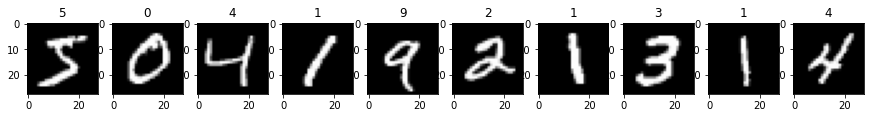

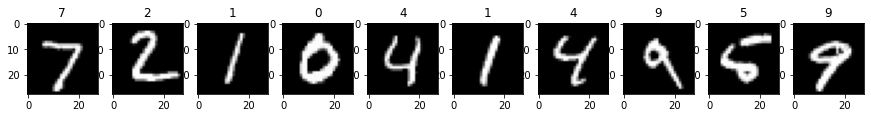

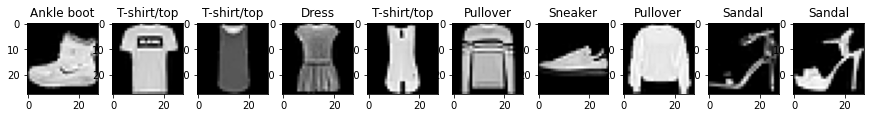

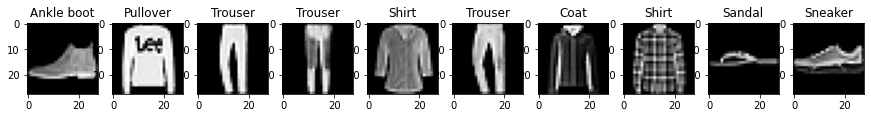

In [4]:
fmnist_labels = "T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot".split(", ")

mnist_train_labels = mnist_train.train_labels.numpy()
mnist_train_data = mnist_train.train_data.numpy()
mnist_test_labels = mnist_test.train_labels.numpy()
mnist_test_data = mnist_test.test_data.numpy()

fmnist_train_data = fmnist_train.train_data.numpy()
fmnist_test_data = fmnist_test.test_data.numpy()
fmnist_train_labels = fmnist_train.train_labels.numpy()
fmnist_train_labels_str = [fmnist_labels[i] for i in 
                           fmnist_train.train_labels.numpy()]
fmnist_test_labels = fmnist_test.train_labels.numpy()
fmnist_test_labels_str = [fmnist_labels[i] for i in
                          fmnist_test.train_labels.numpy()]

subplot_show(mnist_train_data[:10], mnist_train_labels[:10], shape=(1,10))
subplot_show(mnist_test_data[:10], mnist_test_labels[:10], shape=(1,10))
subplot_show(fmnist_train_data[:10], fmnist_train_labels_str[:10], shape=(1,10))
subplot_show(fmnist_test_data[:10], fmnist_test_labels_str[:10], shape=(1,10))

# Data preprocessing

In [5]:
train_loader_mnist = torch.utils.data.DataLoader(
    mnist_train, batch_size=32, shuffle=False, num_workers=4)

test_loader_mnist = torch.utils.data.DataLoader(
    mnist_test, batch_size=32, shuffle=False, num_workers=4)

train_loader_fmnist = torch.utils.data.DataLoader(
    fmnist_train, batch_size=32, shuffle=False, num_workers=4)

test_loader_fmnist = torch.utils.data.DataLoader(
    fmnist_test, batch_size=32, shuffle=False, num_workers=4)

# Autoencoder (simple one)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim * 4)
        
        ## encoder 2 ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim * 4, encoding_dim)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
)


In [7]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 20

for epoch in tqdm(range(1, n_epochs+1), position=0):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader_mnist:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs.sum(), images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader_mnist)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([32, 784])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	Training Loss: 13747.758411
Epoch: 2 	Training Loss: 29.611832
Epoch: 3 	Training Loss: 29.611787
Epoch: 4 	Training Loss: 29.611783
Epoch: 5 	Training Loss: 29.611782
Epoch: 6 	Training Loss: 29.611782
Epoch: 7 	Training Loss: 29.611782
Epoch: 8 	Training Loss: 29.611782
Epoch: 9 	Training Loss: 29.611782
Epoch: 10 	Training Loss: 29.611782
Epoch: 11 	Training Loss: 29.611782
Epoch: 12 	Training Loss: 29.611782
Epoch: 13 	Training Loss: 29.611782
Epoch: 14 	Training Loss: 29.611782
Epoch: 15 	Training Loss: 29.611782
Epoch: 16 	Training Loss: 29.611782
Epoch: 17 	Training Loss: 29.611782
Epoch: 18 	Training Loss: 29.611782
Epoch: 19 	Training Loss: 29.611782
Epoch: 20 	Training Loss: 29.611782



## Spectral clustering attempt

In [8]:
cluster_model = sklearn.cluster.SpectralClustering(n_clusters=10, affinity ='precomputed')

Y = torch.tensor([])
c = 0
for data in train_loader_mnist:
  if c>50:
    break
  c += 1
  images, _ = data
  images = images.view(images.size(0), -1)
  outputs = model(images)
  Y = torch.cat((Y, outputs), 0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<BarContainer object of 32 artists>

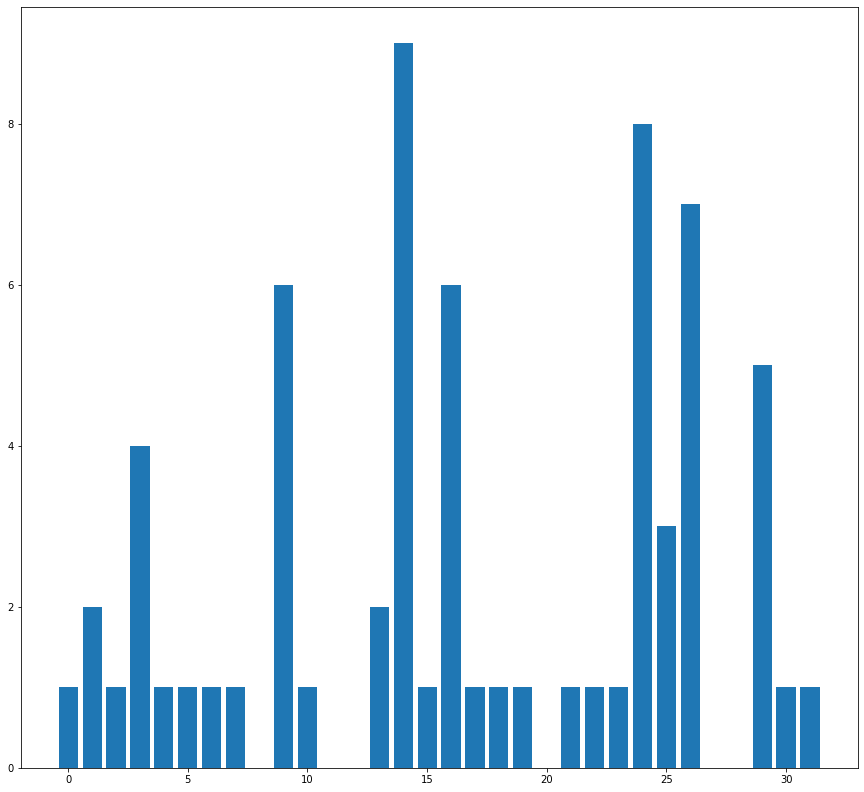

In [9]:
labels = cluster_model.fit_predict(Y[:32].detach().numpy())
plt.bar(np.arange(len(labels)), labels)